In [1]:
%load_ext lab_black

In [2]:
import requests
import pandas as pd
from pandas import json_normalize
import json
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup

In [3]:
plt.style.use("seaborn")

In [4]:
# SEC Edgar database API
# https://www.sec.gov/edgar/sec-api-documentation

# history of submissions of financial report fillings
url_submissions = "https://data.sec.gov/submissions/"

# a few quarters of financial reports
# returns values for the last 4 quarters?
url_facts = "https://data.sec.gov/api/xbrl/companyfacts/"

# hisotry of values for a specific financial report entry (e.g. Revenues)
# for a specific company
# FIXTHEM typo in the official doc
url_concepts = "https://data.sec.gov/api/xbrl/companyconcept/"

# ...
url_frames = "https://data.sec.gov/api/xbrl/frames/"

### companyfacts entry point

In [10]:
# url_facts
# test with Apple Inc.
# Apple Inc. CIK found manually from https://www.sec.gov/edgar/searchedgar/cik.htm

cik = "0000320193"
headers = {"User-Agent": "Anselme Borgeaud (individual) aborgeaud@gmail.com"}


def get_facts(cik: str, headers) -> dict:
    assert len(cik) == 10
    resp = requests.get(
        url_facts + "CIK" + cik + ".json", headers=headers, timeout=5
    )
    resp_json = None
    if resp.status_code < 400:
        resp_json = resp.json()
    return resp_json

In [11]:
resp_json = get_facts(cik, headers)

In [19]:
resp_json['facts'].keys()

dict_keys(['dei', 'us-gaap'])

In [12]:
resp_json["entityName"]

'Apple Inc.'

In [13]:
# keys of resp_json['facts'] are the taxonomies (e.g., us-gaap, ifrs-full, dei, or srt)
resp_json["facts"].keys()

dict_keys(['dei', 'us-gaap'])

In [14]:
gaap = resp_json["facts"]["us-gaap"]

In [15]:
for k in gaap.keys():
    print(k)

AccountsPayable
AccountsPayableCurrent
AccountsReceivableNetCurrent
AccruedIncomeTaxesCurrent
AccruedIncomeTaxesNoncurrent
AccruedLiabilities
AccruedLiabilitiesCurrent
AccruedMarketingCostsCurrent
AccumulatedDepreciationDepletionAndAmortizationPropertyPlantAndEquipment
AccumulatedOtherComprehensiveIncomeLossAvailableForSaleSecuritiesAdjustmentNetOfTax
AccumulatedOtherComprehensiveIncomeLossCumulativeChangesInNetGainLossFromCashFlowHedgesEffectNetOfTax
AccumulatedOtherComprehensiveIncomeLossForeignCurrencyTranslationAdjustmentNetOfTax
AccumulatedOtherComprehensiveIncomeLossNetOfTax
AdjustmentsToAdditionalPaidInCapitalSharebasedCompensationRequisiteServicePeriodRecognitionValue
AdjustmentsToAdditionalPaidInCapitalTaxEffectFromShareBasedCompensation
AdvertisingExpense
AllocatedShareBasedCompensationExpense
AllowanceForDoubtfulAccountsReceivableCurrent
AmortizationOfIntangibleAssets
AntidilutiveSecuritiesExcludedFromComputationOfEarningsPerShareAmount
Assets
AssetsCurrent
AssetsNoncurrent


In [17]:
resp_json["facts"]["dei"].keys()

dict_keys(['EntityCommonStockSharesOutstanding', 'EntityPublicFloat'])

In [54]:
entry = "EarningsPerShareDiluted"

In [21]:
gaap[entry].keys()

dict_keys(['label', 'description', 'units'])

In [22]:
gaap[entry]["units"].keys()

dict_keys(['USD', 'USD/shares'])

In [26]:
values = gaap[entry]["units"]["USD/shares"]

In [27]:
df = json_normalize(values)
df

,start,end,val,accn,fy,fp,form,filed,frame
0,2019-09-29,2020-03-28,1.89,0000320193-21-000056,2021,Q2,10-Q,2021-04-29,NaN
1,2019-12-29,2020-03-28,0.64,0000320193-21-000056,2021,Q2,10-Q,2021-04-29,CY2020Q1
2,2019-09-29,2020-06-27,2.54,0000320193-21-000065,2021,Q3,10-Q,2021-07-28,NaN
3,2020-03-29,2020-06-27,0.65,0000320193-21-000065,2021,Q3,10-Q,2021-07-28,CY2020Q2
4,2020-09-27,2021-03-27,3.08,0000320193-21-000056,2021,Q2,10-Q,2021-04-29,NaN
5,2020-12-27,2021-03-27,1.40,0000320193-21-000056,2021,Q2,10-Q,2021-04-29,CY2021Q1
6,2020-09-27,2021-06-26,4.38,0000320193-21-000065,2021,Q3,10-Q,2021-07-28,NaN
7,2021-03-28,2021-06-26,1.30,0000320193-21-000065,2021,Q3,10-Q,2021-07-28,CY2021Q2


<AxesSubplot:xlabel='frame'>

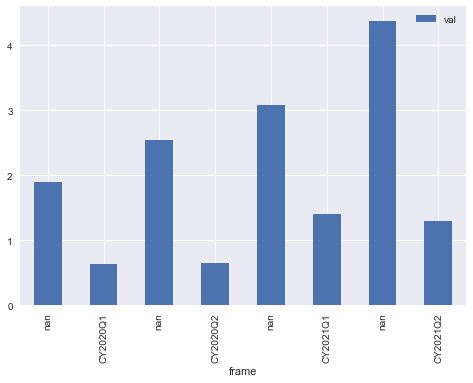

In [28]:
df.plot(x="frame", y="val", kind="bar")

### companyconcepts entry point

In [61]:
# submissions


def get_concepts(cik: str, entry: str, headers: dict, taxonomy="us-gaap") -> dict:
    assert len(cik) == 10
    resp = requests.get(
        url_concepts + "CIK" + cik + "/" + taxonomy + "/" + entry + ".json",
        headers=headers,
        timeout=5,
    )

    resp_json = None
    if resp.status_code < 400:
        resp_json = resp.json()
    return resp_json

In [62]:
taxonomy = "us-gaap"

resp_json = get_concepts(cik, entry, headers, taxonomy)

In [63]:
resp_json.keys()

dict_keys(['cik', 'taxonomy', 'tag', 'label', 'description', 'entityName', 'units'])

In [64]:
resp_json["units"].keys()

dict_keys(['USD', 'USD/shares'])

In [67]:
df_usd = json_normalize(resp_json["units"]["USD"])

In [69]:
df_usdpershare = json_normalize(resp_json["units"]["USD/shares"])

In [72]:
df_usd.head()

,start,end,val,accn,fy,fp,form,filed,frame
0,2006-10-01,2007-09-29,3.93,0001193125-09-214859,2009,FY,10-K,2009-10-27,NaN
1,2006-10-01,2007-09-29,3.93,0001193125-10-012091,2009,FY,10-K/A,2010-01-25,CY2007
2,2007-09-30,2008-06-28,4.10,0001193125-09-153165,2009,Q3,10-Q,2009-07-22,NaN
3,2008-03-30,2008-06-28,1.19,0001193125-09-153165,2009,Q3,10-Q,2009-07-22,CY2008Q2
4,2007-09-30,2008-09-27,5.36,0001193125-09-214859,2009,FY,10-K,2009-10-27,NaN


In [70]:
df_usd.tail()

,start,end,val,accn,fy,fp,form,filed,frame
260,2020-03-29,2020-06-27,2.58,0000320193-20-000062,2020,Q3,10-Q,2020-07-31,NaN
261,2020-03-29,2020-06-27,0.65,0000320193-20-000096,2020,FY,10-K,2020-10-30,CY2020Q2
262,2019-09-29,2020-09-26,3.28,0000320193-20-000096,2020,FY,10-K,2020-10-30,CY2020
263,2020-06-28,2020-09-26,0.73,0000320193-20-000096,2020,FY,10-K,2020-10-30,CY2020Q3
264,2020-09-27,2020-12-26,1.68,0000320193-21-000010,2021,Q1,10-Q,2021-01-28,CY2020Q4


In [71]:
df_usdpershare.head()

,start,end,val,accn,fy,fp,form,filed,frame
0,2019-09-29,2020-03-28,1.89,0000320193-21-000056,2021,Q2,10-Q,2021-04-29,NaN
1,2019-12-29,2020-03-28,0.64,0000320193-21-000056,2021,Q2,10-Q,2021-04-29,CY2020Q1
2,2019-09-29,2020-06-27,2.54,0000320193-21-000065,2021,Q3,10-Q,2021-07-28,NaN
3,2020-03-29,2020-06-27,0.65,0000320193-21-000065,2021,Q3,10-Q,2021-07-28,CY2020Q2
4,2020-09-27,2021-03-27,3.08,0000320193-21-000056,2021,Q2,10-Q,2021-04-29,NaN


In [45]:
# company concepts

concepts = requests.get(
    f"https://data.sec.gov/api/xbrl/companyconcept/CIK{apple_cik}/us-gaap/AccountsPayableCurrent.json",
    headers=headers,
)


# https://data.sec.gov/api/xbrl/companyconcepts/CIK0000320193/us-gaap/Assets.json

concepts_json = concepts.json()

In [44]:
concepts_json.keys()

dict_keys(['cik', 'taxonomy', 'tag', 'label', 'description', 'entityName', 'units'])

In [159]:
df_accpay = json_normalize(concepts_json["units"]["USD"])
df_accpay

,end,val,accn,fy,fp,form,filed,frame
0,2008-09-27,5520000000,0001193125-09-214859,2009,FY,10-K,2009-10-27,NaN
1,2008-09-27,5520000000,0001193125-10-012091,2009,FY,10-K/A,2010-01-25,CY2008Q3I
2,2009-09-26,5601000000,0001193125-09-214859,2009,FY,10-K,2009-10-27,NaN
3,2009-09-26,5601000000,0001193125-10-012085,2010,Q1,10-Q,2010-01-25,NaN
4,2009-09-26,5601000000,0001193125-10-012091,2009,FY,10-K/A,2010-01-25,NaN
...,...,...,...,...,...,...,...,...
97,2020-09-26,42296000000,0000320193-21-000056,2021,Q2,10-Q,2021-04-29,NaN
98,2020-09-26,42296000000,0000320193-21-000065,2021,Q3,10-Q,2021-07-28,CY2020Q3I
99,2020-12-26,63846000000,0000320193-21-000010,2021,Q1,10-Q,2021-01-28,CY2020Q4I
100,2021-03-27,40127000000,0000320193-21-000056,2021,Q2,10-Q,2021-04-29,CY2021Q1I


In [160]:
df_accpay_quarterly = df_accpay[df_revenues["fp"].str.contains("Q")]

In [161]:
df_accpay_quarterly["period"] = (
    df_accpay_quarterly["fy"].astype("str") + df_accpay_quarterly["fp"]
)

/var/folders/57/h9v24nzx4pj9gx46p1yhvwxm0000gn/T/ipykernel_95956/3969407865.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_accpay_quarterly["period"] = (


<AxesSubplot:xlabel='period'>

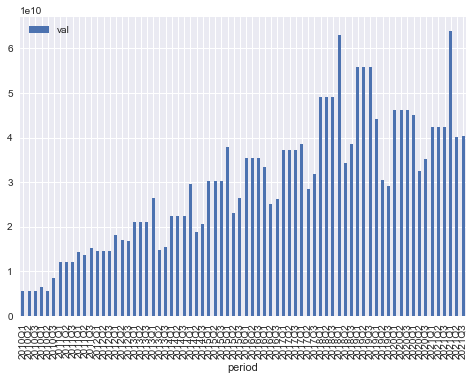

In [162]:
df_accpay_quarterly.plot(x="period", y="val", kind="bar")

# Yahoo Finance API

In [173]:
from datetime import datetime, date, time, timezone


def yahoo_url(ticker: str, from_day: str, to_day: str) -> str:
    """Get url to request yahoo finance."""
    from_dt = int(
        datetime.combine(
            date.fromisoformat(from_day), time(), tzinfo=timezone.utc
        ).timestamp()
    )
    to_dt = int(
        datetime.combine(
            date.fromisoformat(to_day), time(), tzinfo=timezone.utc
        ).timestamp()
    )
    return (
        "https://query1.finance.yahoo.com/v7/finance/download/"
        f"{ticker.upper()}"
        f"?period1={from_dt}&period2={to_dt}&interval=1d"
        "&events=history&includeAdjustedClose=true"
    )

In [174]:
ticker = "AAPL"
from_day = "2021-01-01"
to_day = "2021-09-01"

url = yahoo_url(ticker, from_day, to_day)
headers = {"User-Agent": "Chrome/92.0.4515.159"}

resp = requests.get(url, headers=headers, timeout=5)
print(resp.status_code)

200


In [187]:
ticker_infos = resp.content.decode("utf-8")

In [189]:
import io

df_ticker = pd.read_csv(io.StringIO(ticker_infos))
df_ticker

,Date,Open,High,Low,Close,Adj Close,Volume
0,2021-01-04,133.520004,133.610001,126.760002,129.410004,128.804825,143301900
1,2021-01-05,128.889999,131.740005,128.429993,131.009995,130.397324,97664900
2,2021-01-06,127.720001,131.050003,126.379997,126.599998,126.007957,155088000
3,2021-01-07,128.360001,131.630005,127.860001,130.919998,130.307755,109578200
4,2021-01-08,132.429993,132.630005,130.229996,132.050003,131.432465,105158200
...,...,...,...,...,...,...,...
162,2021-08-25,149.809998,150.320007,147.800003,148.360001,148.360001,58991300
163,2021-08-26,148.350006,149.119995,147.509995,147.539993,147.539993,48597200
164,2021-08-27,147.479996,148.750000,146.830002,148.600006,148.600006,55721500
165,2021-08-30,149.000000,153.490005,148.610001,153.119995,153.119995,90956700


In [191]:
df_ticker["Date"] = pd.to_datetime(df_ticker["Date"])

<AxesSubplot:xlabel='Date'>

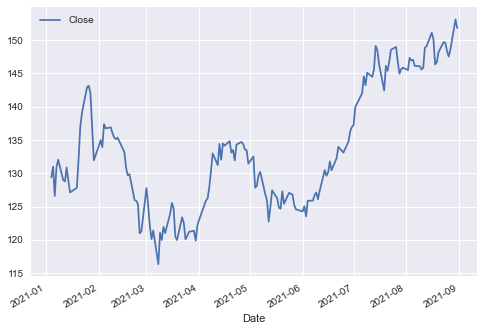

In [192]:
df_ticker.plot(x="Date", y="Close", kind="line")